In [1]:
import torch
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import random
import matplotlib.pyplot as plt

In [2]:
# Utility Functions
def gaussian_kl(mu1, logsigma1, mu2, logsigma2):
    """Computes the KL divergence between two diagonal Gaussians."""
    return -0.5 + logsigma2 - logsigma1 + 0.5 * (logsigma1.exp() ** 2 + (mu1 - mu2) ** 2) / (logsigma2.exp() ** 2)


def sample_latent(mu, logvar, prev_z=None):
    """Samples a latent variable conditioned on the previous latent."""
    eps = torch.empty_like(mu).normal_(0., 1.)
    z = torch.exp(logvar) * eps + mu
    if prev_z is not None:
        z = z + prev_z
    return z


def get_conv(in_dim, out_dim, kernel_size=3, stride=1, padding=1):
    """Creates a 2D convolutional layer."""
    c = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding)
    nn.init.kaiming_normal_(c.weight)
    return c


def get_3x3(in_dim, out_dim):
    """Creates a 3x3 convolutional layer."""
    return get_conv(in_dim, out_dim, 3, 1, 1)


# Encoder Module
class HierarchicalEncoder(nn.Module):
    def __init__(self, in_channels=3, base_width=32, latent_dims=[32, 64, 128]):
        super().__init__()
        self.in_conv = get_3x3(in_channels, base_width)

        self.down1 = nn.Sequential(get_3x3(base_width, 64), nn.ReLU(), nn.MaxPool2d(2))  # 16x16 → 8x8
        self.down2 = nn.Sequential(get_3x3(64, 128), nn.ReLU(), nn.MaxPool2d(2))  # 8x8 → 4x4

        # Latent layers
        self.fc_mu1 = nn.Linear(128 * 4 * 4, latent_dims[0])
        self.fc_logvar1 = nn.Linear(128 * 4 * 4, latent_dims[0])

    def forward(self, x):
        x0 = self.in_conv(x)
        x1 = self.down1(x0)  # Expected: (batch, 64, 8, 8)
        x2 = self.down2(x1)  # Expected: (batch, 128, 4, 4)

        mu1, logvar1 = self.fc_mu1(x2.view(x2.size(0), -1)), self.fc_logvar1(x2.view(x2.size(0), -1))

        return [(mu1, logvar1)]


# Decoder Module
class HierarchicalDecoder(nn.Module):
    def __init__(self, latent_dims=[32, 64, 128], base_width=32, out_channels=3):
        super().__init__()
        self.fc1 = nn.Linear(latent_dims[0], 128 * 4 * 4)
        self.fc2 = nn.Linear(latent_dims[1], 64 * 8 * 8)
        self.fc3 = nn.Linear(latent_dims[2], 32 * 16 * 16)

        self.up1 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), get_3x3(128, 64), nn.ReLU())  # 4x4 → 8x8
        #self.up1 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.ReLU())
        self.up2 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), get_3x3(64, 32), nn.ReLU())  # 8x8 → 16x16
        self.up3 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), get_3x3(32, base_width), nn.ReLU())  # 16x16 → 32x32

        self.out_conv = get_3x3(base_width, out_channels)  # output layer

    def forward(self, z_hierarchical):
        z1, = z_hierarchical

        x1 = self.fc1(z1).view(-1, 128, 4, 4)
        x1 = self.up1(x1)  # (batch, 64, 8, 8)

        x2 = self.up2(x1)  # (batch, 32, 16, 16)

        x3 = self.up3(x2)  # (batch, base_width, 32, 32)

        return torch.sigmoid(self.out_conv(x3))  # Ensure output matches target


# Hierarchical VDVAE Model
class HierarchicalVDVAE(nn.Module):
    def __init__(self, in_channels=3, base_width=32, latent_dims = [64, 128, 256]):
        super().__init__()
        self.encoder = HierarchicalEncoder(in_channels, base_width, latent_dims)
        self.decoder = HierarchicalDecoder(latent_dims, base_width, in_channels)

    def forward(self, x):
        latents = self.encoder(x)

        # Hierarchical latent sampling with projection
        z1 = sample_latent(latents[0][0], latents[0][1])

        sampled_latents = [z1]
        recon_x = self.decoder(sampled_latents)
        return recon_x, latents


In [3]:
# device
cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

# data
scale_factor = 2
image_size = 32
num_channels = 3

# model
latent_dims = [64, 128, 256]
#latent_dims = [256, 512,1024]
#latent_dims = [128, 256, 512]
#latent_dims = [32, 64, 128]

# training
batch_size = 512
num_epochs = 15
save_interval = num_epochs
validation_interval = 5

#checkpointing
checkpoint_dir = "./checkpoints/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cuda


In [4]:
from datasets import CIFAR_SR

train_dataset = CIFAR_SR(scale_factor=scale_factor, split="train", download=True, device=DEVICE)
val_dataset = CIFAR_SR(scale_factor=scale_factor, split="test", download=True, device=DEVICE)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
model = HierarchicalVDVAE(in_channels=num_channels, latent_dims=latent_dims).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [6]:
from torchvision import models

class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:16]  # Use first layers
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG weights
        self.vgg = vgg

    def forward(self, pred, target):
        pred_features = self.vgg(pred)
        target_features = self.vgg(target)
        return F.mse_loss(pred_features, target_features, reduction="mean")  # Feature-level loss
    
perceptual_criterion = PerceptualLoss().to(DEVICE)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def loss_function(recon_x, x, latents, perceptual_criterion, alpha=1.0, beta=1.0):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')

    # KL divergence
    kl_loss = 0
    for mu, logvar in latents:
        kl_loss += torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar)))
    kl_loss /= len(latents)

    # Perceptual loss
    perceptual_loss = perceptual_criterion(recon_x, x)

    # total loss
    total_loss = alpha * recon_loss + beta * kl_loss + perceptual_loss
    return total_loss, recon_loss, kl_loss, perceptual_loss

In [8]:
total_training_start = time.time()  # Start time for overall training

loss_history = {"total_loss": [], "recon_loss": [], "kl_loss": [], "perceptual_loss": []}
val_loss_history = {"total_loss": [], "recon_loss": [], "kl_loss": [], "perceptual_loss": []}

for epoch in range(num_epochs):
    epoch_start = time.time()  # Start time for the epoch

    model.train()
    total_loss, total_recon_loss, total_kl_loss, total_perceptual_loss = [], [], [], []

    # Training
    for hr_imgs, lr_imgs in train_loader:

        optimizer.zero_grad()
        recon_imgs, latents = model(lr_imgs)

        # Loss computation
        loss, recon_loss, kl_loss, perceptual_loss = loss_function(recon_imgs, hr_imgs, latents, perceptual_criterion, alpha=0, beta=1.0)

        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())
        total_recon_loss.append(recon_loss.item())
        total_kl_loss.append(kl_loss.item())
        total_perceptual_loss.append(perceptual_loss.item())

    scheduler.step()  # Adjust learning rate

    epoch_end = time.time()  # End time for the epoch
    epoch_time = epoch_end - epoch_start

    loss_history["total_loss"].append(np.mean(total_loss))
    loss_history["recon_loss"].append(np.mean(total_recon_loss))
    loss_history["kl_loss"].append(np.mean(total_kl_loss))
    loss_history["perceptual_loss"].append(np.mean(total_perceptual_loss))

    print(f"Epoch [{epoch+1}/{num_epochs}] | Time: {epoch_time:.2f}s | TotalLoss: {loss_history["total_loss"][-1]:.6f} | Perceptual: {loss_history["perceptual_loss"][-1]:.6f} | Recon: {loss_history["recon_loss"][-1]:.6f} | KL: {loss_history["kl_loss"][-1]:.6f}")

    # Validation
    if (epoch + 1) % validation_interval == 0:
        model.eval()
        with torch.no_grad():
            total_val_loss, total_val_recon_loss, total_val_kl_loss, total_val_perceptual_loss = [], [], [], []
            for hr_imgs, lr_imgs in val_loader:
                recon_imgs, latents = model(lr_imgs)

                # Loss computation
                val_total_loss, val_recon_loss, val_kl_loss, val_perceptual_loss = loss_function(recon_imgs, hr_imgs, latents, perceptual_criterion, alpha=0, beta=1.0)

                total_val_loss.append(val_total_loss.item())
                total_val_recon_loss.append(val_recon_loss.item())
                total_val_kl_loss.append(val_kl_loss.item())
                total_val_perceptual_loss.append(val_perceptual_loss.item())

            val_loss_history["total_loss"].append(np.mean(total_val_loss))
            val_loss_history["recon_loss"].append(np.mean(total_val_recon_loss))
            val_loss_history["kl_loss"].append(np.mean(total_val_kl_loss))
            val_loss_history["perceptual_loss"].append(np.mean(total_val_perceptual_loss))

            print(f"Validation | TotalLoss: {val_loss_history["total_loss"][-1]:.6f} | Perceptual: {val_loss_history["perceptual_loss"][-1]:.6f} | Recon: {val_loss_history["recon_loss"][-1]:.6f} | KL: {val_loss_history["kl_loss"][-1]:.6f}")

    # Save checkpoint
    if (epoch + 1) % save_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"vae_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

total_training_end = time.time()  # End time for overall training
total_training_time = total_training_end - total_training_start
print(f"Total Training Time: {total_training_time:.2f}s")

Epoch [1/15] | Time: 60.47s | TotalLoss: 7.539947 | Perceptual: 7.399706 | Recon: 0.066208 | KL: 0.140241
Epoch [2/15] | Time: 61.95s | TotalLoss: 7.191152 | Perceptual: 7.147999 | Recon: 0.065569 | KL: 0.043153
Epoch [3/15] | Time: 61.28s | TotalLoss: 7.061749 | Perceptual: 6.995452 | Recon: 0.065819 | KL: 0.066297
Epoch [4/15] | Time: 59.41s | TotalLoss: 6.929575 | Perceptual: 6.841723 | Recon: 0.065910 | KL: 0.087852
Epoch [5/15] | Time: 62.51s | TotalLoss: 6.821061 | Perceptual: 6.719522 | Recon: 0.066297 | KL: 0.101539
Validation | TotalLoss: 6.792563 | Perceptual: 6.680724 | Recon: 0.066313 | KL: 0.111839
Epoch [6/15] | Time: 59.40s | TotalLoss: 6.733987 | Perceptual: 6.619967 | Recon: 0.066625 | KL: 0.114020
Epoch [7/15] | Time: 58.84s | TotalLoss: 6.659577 | Perceptual: 6.534755 | Recon: 0.066858 | KL: 0.124822
Epoch [8/15] | Time: 58.55s | TotalLoss: 6.597494 | Perceptual: 6.465516 | Recon: 0.067004 | KL: 0.131979
Epoch [9/15] | Time: 57.17s | TotalLoss: 6.543795 | Perceptual:

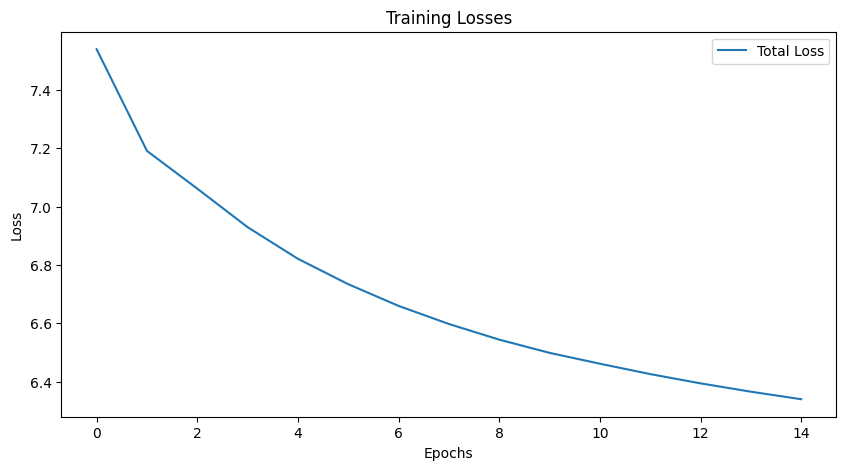

In [10]:
# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history["total_loss"], label="Total Loss")
# plt.plot(loss_history["recon_loss"], label="Reconstruction Loss")
# plt.plot(loss_history["kl_loss"], label="KL Divergence")
# plt.plot(loss_history["perceptual_loss"], label="Perceptual Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.show()

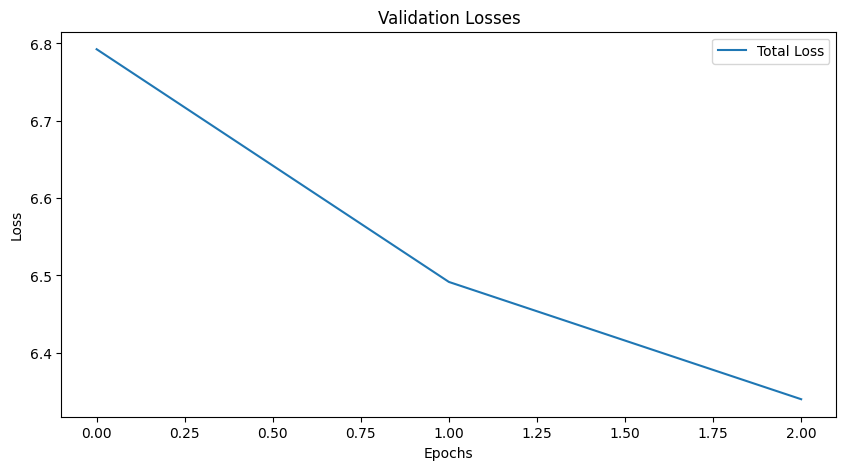

In [11]:
# Plot validation loss history
plt.figure(figsize=(10, 5))
plt.plot(val_loss_history["total_loss"], label="Total Loss")
# plt.plot(val_loss_history["recon_loss"], label="Reconstruction Loss")
# plt.plot(val_loss_history["kl_loss"], label="KL Divergence")
# plt.plot(val_loss_history["perceptual_loss"], label="Perceptual Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Losses")
plt.legend()
plt.show()

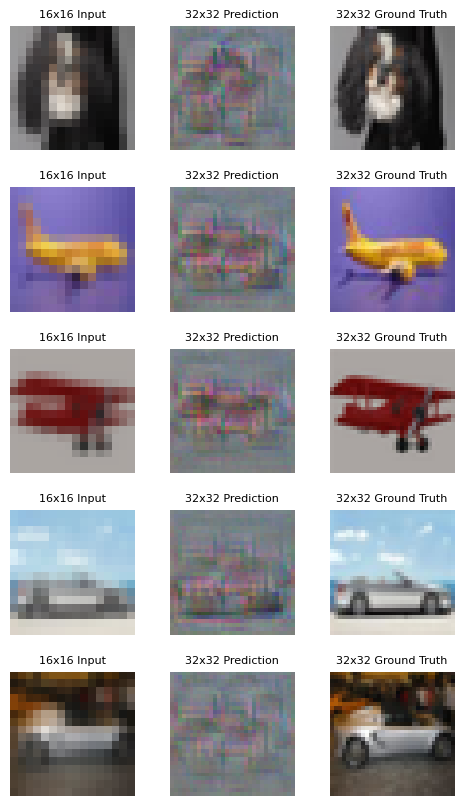

In [12]:
# Generate and Visualize Random Samples
def visualize_samples(model, num_samples=5):
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(num_samples, 3, figsize=(6, num_samples * 2))  # Reduced figure size

        # Randomly select `num_samples` indices from the validation dataset
        random_indices = random.sample(range(len(val_dataset)), num_samples)

        for i, idx in enumerate(random_indices):
            hr_img, lr_img = val_dataset[idx]  # Get a random sample
            hr_img, lr_img = hr_img.unsqueeze(0), lr_img.unsqueeze(0)

            # Predict 32x32 from 16x16 input
            recon_img, _ = model(lr_img)

            # Convert tensors to numpy for visualization
            lr_img_np = lr_img.cpu().numpy().squeeze()  # (3, 16, 16) for color
            hr_img_np = hr_img.cpu().numpy().squeeze()  # (3, 32, 32)
            recon_img_np = recon_img.cpu().numpy().squeeze()  # (3, 32, 32)

            # Permute dimensions from (C, H, W) → (H, W, C) for Matplotlib
            lr_img_np = np.transpose(lr_img_np, (1, 2, 0))  # Now (16, 16, 3)
            hr_img_np = np.transpose(hr_img_np, (1, 2, 0))  # Now (32, 32, 3)
            recon_img_np = np.transpose(recon_img_np, (1, 2, 0))  # Now (32, 32, 3)

            # Plot images with smaller size
            axs[i, 0].imshow(lr_img_np)
            axs[i, 0].set_title("16x16 Input", fontsize=8)
            axs[i, 0].axis("off")

            axs[i, 1].imshow(recon_img_np)
            axs[i, 1].set_title("32x32 Prediction", fontsize=8)
            axs[i, 1].axis("off")

            axs[i, 2].imshow(hr_img_np)
            axs[i, 2].set_title("32x32 Ground Truth", fontsize=8)
            axs[i, 2].axis("off")

        # Adjust layout for smaller images
        plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Reduce space between images
        plt.show()

# Run visualization
visualize_samples(model, num_samples=5)


In [13]:
from util import save_model

save_model(model, "cifar_vae.pth")

In [14]:
from util import load_model

model = HierarchicalVDVAE(in_channels=num_channels, latent_dims=latent_dims).to(DEVICE)
model = load_model(model, "cifar_vae.pth")

In [15]:
x, x_inp = val_dataset.get_samples(64)
x = x.to(DEVICE)
x_inp = x_inp.to(DEVICE)
x_hat, _ = model(x_inp)

In [16]:
from metrics import validation_scores

psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, x, x_inp)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val.mean())
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

PSNR: tensor(12.1807, device='cuda:0', grad_fn=<MeanBackward1>)
SSIM: tensor(0.0795, device='cuda:0', grad_fn=<MeanBackward0>)
LPIPS: tensor(0.6287, device='cuda:0', grad_fn=<MeanBackward1>)
BRISQUE: tensor(78.9692, device='cuda:0', grad_fn=<MeanBackward1>)
PSNR Consistency: tensor(26.5133, device='cuda:0')
MSE Diversity: tensor(0.0658, device='cuda:0', grad_fn=<DivBackward0>)
LPIPS Diversity: tensor(0.6219, device='cuda:0', grad_fn=<DivBackward0>)
